In [1]:
import pynucastro as pyna
from pynucastro.screening import chugunov_2009

First we will generate the `subch_approx` network.  This is based on the `aprox13` network, but with some extra rates to bypass ${}^{12}\mathrm{C}(\alpha,\gamma){}^{16}\mathrm{O}$ and more complete carbon and oxygen burning.

In particular it:
* uses the $(\alpha,p)(p,\gamma)$ approximation
* modifies some rates to make neutron captures instantaneous

In [3]:
rl = pyna.ReacLibLibrary()

nucs = ["p", "he4",
        "c12", "o16", "ne20",
        "mg24", "si28", "s32",
        "ar36", "ca40", "ti44",
        "cr48", "fe52", "ni56",
        "al27", "p31", "cl35",
        "k39", "sc43", "v47",
        "mn51", "co55",
        "n13", "n14", "f18",
        "ne21", "na22", "na23"]

subch = rl.linking_nuclei(nucs)

other = [(("c12", "c12"), ("mg23", "n"), ("mg24")),
         (("o16", "o16"), ("s31", "n"), ("s32")),
         (("c12", "o16"), ("si27", "n"), ("si28"))]

for r, p, mp in other:
    rfilter = pyna.RateFilter(reactants=r,
                              products=p)
    _library = rl.filter(rfilter)
    r = _library.get_rates()[0]
    r.modify_products(mp)
    subch += _library

net = pyna.PythonNetwork(libraries=[subch],
                         symmetric_screening=True)
net.make_ap_pg_approx(intermediate_nuclei=["cl35", "k39", "sc43",
                                           "v47", "mn51", "co55"])
net.remove_nuclei(["cl35", "k39", "sc43",
                   "v47", "mn51", "co55"])

using approximate rate S32 + He4 ⟶ Ar36 + 𝛾
using approximate rate Ar36 ⟶ S32 + He4
using approximate rate Ar36 + He4 ⟶ Ca40 + 𝛾
using approximate rate Ca40 ⟶ Ar36 + He4
using approximate rate Ca40 + He4 ⟶ Ti44 + 𝛾
using approximate rate Ti44 ⟶ Ca40 + He4
using approximate rate Ti44 + He4 ⟶ Cr48 + 𝛾
using approximate rate Cr48 ⟶ Ti44 + He4
using approximate rate Cr48 + He4 ⟶ Fe52 + 𝛾
using approximate rate Fe52 ⟶ Cr48 + He4
using approximate rate Fe52 + He4 ⟶ Ni56 + 𝛾
using approximate rate Ni56 ⟶ Fe52 + He4
removing rate S32 + He4 ⟶ Ar36 + 𝛾
removing rate S32 + He4 ⟶ p + Cl35
removing rate Cl35 + p ⟶ Ar36 + 𝛾
removing rate Ar36 ⟶ He4 + S32
removing rate Ar36 ⟶ p + Cl35
removing rate Cl35 + p ⟶ He4 + S32
removing rate Ar36 + He4 ⟶ Ca40 + 𝛾
removing rate Ar36 + He4 ⟶ p + K39
removing rate K39 + p ⟶ Ca40 + 𝛾
removing rate Ca40 ⟶ He4 + Ar36
removing rate Ca40 ⟶ p + K39
removing rate K39 + p ⟶ He4 + Ar36
removing rate Ca40 + He4 ⟶ Ti44 + 𝛾
removing rate Ca40 + He4 ⟶ p + Sc43
removing rate 

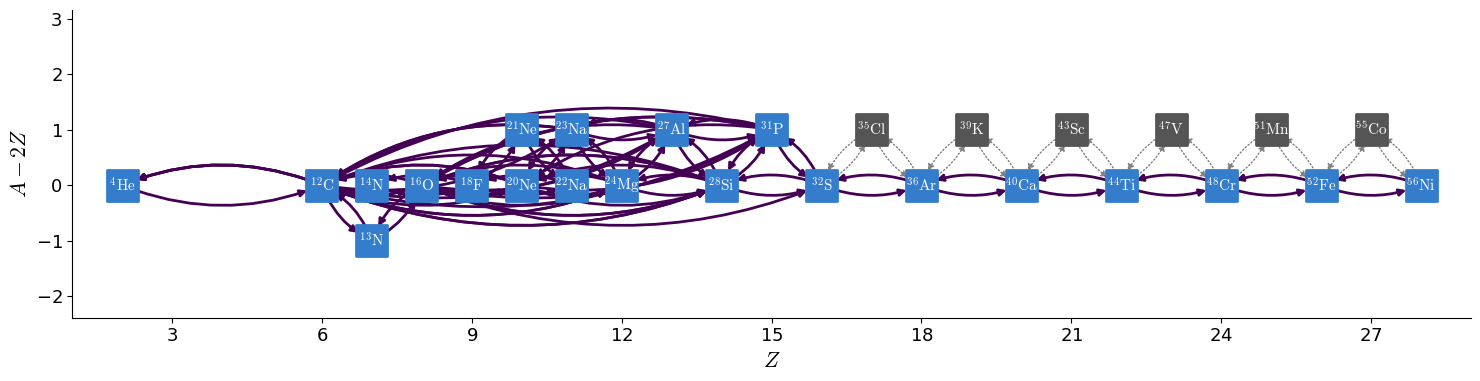

In [4]:
net.plot(rotated=True, curved_edges=True, hide_xp=True,
         hide_xalpha=True, size=(1500, 400),
         node_size=500, node_font_size=11, node_color="#337dcc", node_shape="s",
         outfile="subch_approx.pdf")

In [5]:
net.write_network("subcha.py")

Now we'll integrate this in python

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import subcha

In [7]:
rho = 1.e6
T = 2.e9

X0 = np.zeros(subcha.nnuc)
X0[subcha.jhe4] = 0.99
X0[subcha.jn14] = 0.01

Y0 = X0/subcha.A

In [8]:
tmax = 1.e-3

sol = solve_ivp(subcha.rhs, [0, tmax], Y0, method="BDF", jac=subcha.jacobian,
                dense_output=True, args=(rho, T, chugunov_2009), rtol=1.e-6, atol=1.e-10)

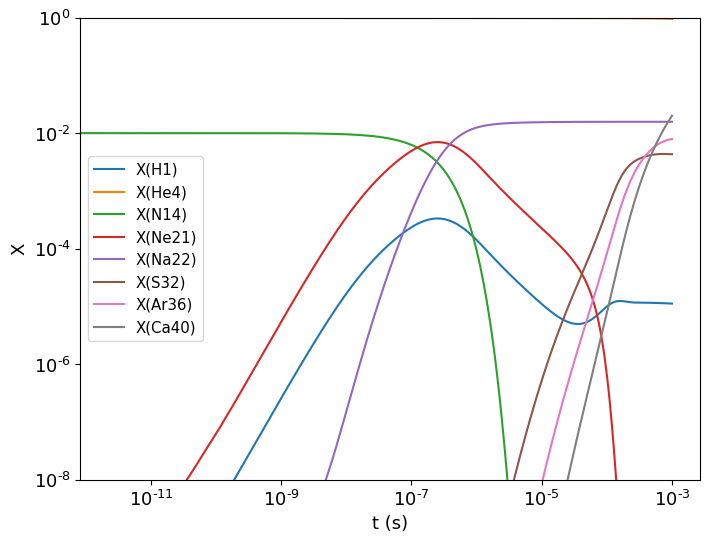

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

threshold = 1.e-4

for i in range(subcha.nnuc):
    if (sol.y[i,:]).max() > threshold:
        ax.loglog(sol.t, sol.y[i,:] * subcha.A[i], label=f"X({subcha.names[i].capitalize()})")

ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

fig.set_size_inches((8, 6))

Here's the final composition

In [10]:
sum = 0.0
for n in range(subcha.nnuc):
    print(subcha.names[n], sol.y[n,-1]*subcha.A[n])
    sum += sol.y[n,-1]*subcha.A[n]

h1 1.118201750354812e-05
he4 0.9501234835426321
c12 0.00041421018807020647
n13 4.732542522551977e-09
n14 6.152749594999212e-24
o16 0.00013555530713842403
f18 1.6337697094274599e-18
ne20 3.599726401800994e-05
ne21 4.147525620078749e-10
na22 0.015714285279783052
na23 1.033638307896702e-06
mg24 5.6656262443941736e-05
al27 0.00016982917743477196
si28 0.0006524065969341593
p31 0.00015027099540079606
s32 0.00431181320679923
ar36 0.00790586186159202
ca40 0.019962679209173412
ti44 0.00035151334950056105
cr48 3.213612126105727e-06
fe52 3.343483448911029e-09
ni56 3.639444609917871e-13


# Comparison plot

Now let's try to output at 100 different times

In [11]:
tfirst = 1.e-10
tmax = 1.e-3
npts = 100
times = np.logspace(np.log10(tfirst), np.log10(tmax), npts)

In [12]:
t = 0.0
state = np.zeros((npts+1, subcha.nnuc))
state[0, :] = np.array(Y0)
for i in range(npts):
    tend = times[i]
    dt = tend - t
    sol = solve_ivp(subcha.rhs, [0, dt], state[i, :], method="BDF", jac=subcha.jacobian,
                dense_output=True, args=(rho, T, chugunov_2009), rtol=1.e-6, atol=1.e-10)
    t += dt
    state[i+1, :] = np.array(sol.y[:,-1])

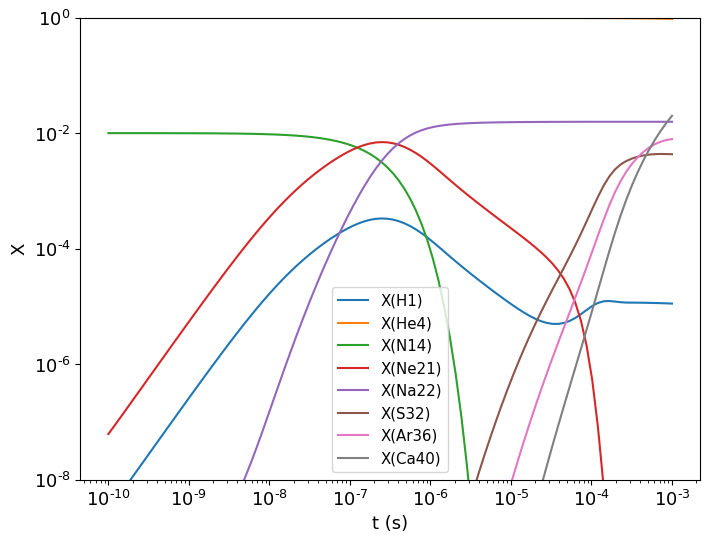

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

threshold = 1.e-4

for i in range(subcha.nnuc):
    if (state[1:,i]).max() > threshold:
        ax.loglog(times, state[1:,i] * subcha.A[i], label=f"X({subcha.names[i].capitalize()})")

ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

fig.set_size_inches((8, 6))

# C++ 

in `Microphysics/unit_test/burn_cell` do:

```
make NETWORK_DIR=subch_approx SCREEN_METHOD=chugunov2009 -j 4
./main3d.gnu.ex inputs_subch_compare
```

In [14]:
cxx = np.genfromtxt("state_over_time.txt", names=True)

Text(0, 0.5, 'X')

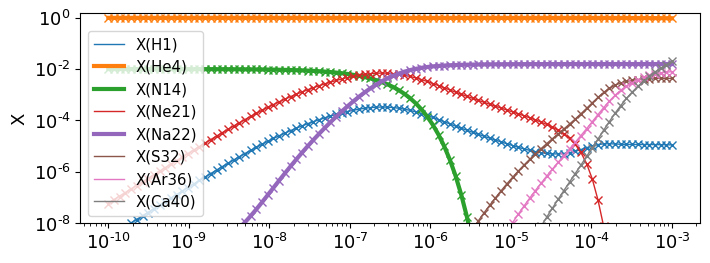

In [18]:
fig = plt.figure()
ax = fig.add_subplot(211)

threshold = 5.e-5

icolor = 0

for i in range(subcha.nnuc):
    x_max = state[1:,i].max()
    if x_max > threshold:
        lw = 1
        if x_max > 10 * threshold:
            lw = 3
        ax.loglog(times, state[1:,i] * subcha.A[i],
                  color=f"C{icolor}", linewidth=lw,
                  label=f"X({subcha.names[i].capitalize()})")
        ax.loglog(cxx["Time"], cxx[subcha.names[i]],
                  linestyle="none",
                  color=f"C{icolor}", marker="x")
        icolor += 1

ax.set_ylim(1.e-8, 1.5)
ax.legend(fontsize="small", loc=3)
#ax.set_xlabel("t (s)")
ax.set_ylabel("X")

In [19]:
ax = fig.add_subplot(212)

threshold = 5.e-5

icolor = 0

for i in range(subcha.nnuc):
    x_max = state[1:,i].max()
    if x_max > threshold:
        lw = 1
        if x_max > 10 * threshold:
            lw = 3
        X_py = state[1:,i] * subcha.A[i]
        X_cxx = cxx[subcha.names[i]]
        err = np.abs(X_py - X_cxx[1:])
        ax.loglog(times, err,
                  color=f"C{icolor}", linewidth=lw,
                  label=f"X({subcha.names[i].capitalize()})")
        icolor += 1
ax.set_ylim(1.e-14, 1.e-6)
#ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("$|X_\mathrm{python} - X_\mathrm{C++}|$")

fig.set_size_inches((8, 10))

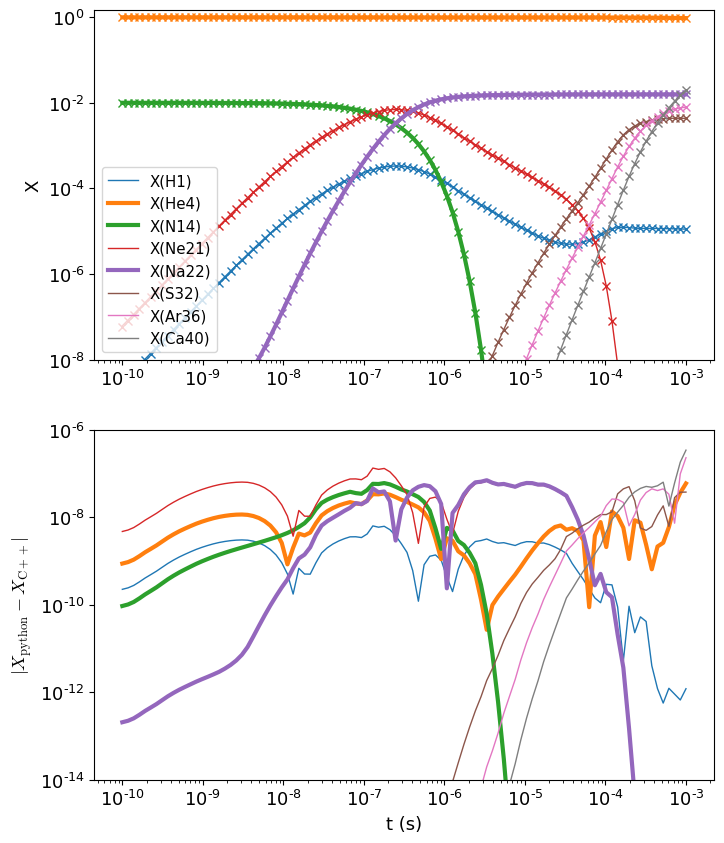

In [20]:
fig

In [21]:
fig.tight_layout()
fig.savefig("cxx_compare.pdf", bbox_inches="tight")